In [4]:
########IMPORTANTE########
#O ARQUIVO DE DADOS POSSUI 144Mbytes, PORTANTO NÃO PODE SER ENVIADO PELO GITHUB. O LINK DELE ESTÁ DISPONIBILIZADO ABAIXO:
#https://www.kaggle.com/dalpozz/creditcardfraud

In [5]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import zeros_like
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import seaborn as sns
import matplotlib.gridspec as gridspec

In [6]:
df = pd.read_csv('creditcard.csv',sep=",")

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# separando dataset em base de treinamento e em base de teste


clas = df['Class'].values #fraude ou não
feat = df.drop(['Class'],axis=1).values #features
feat_train, feat_test, clas_train, clas_test = train_test_split(feat, clas, test_size=0.3, stratify=clas)

print("Tamanho da base treinamento: ", len(clas_train))
print("Fraudes na base treinamento: ", sum(clas_train))
print("Tamanho da base teste: ", len(clas_test))
print("Fraudes na base teste: ", sum(clas_test))

Tamanho da base treinamento:  199364
Fraudes na base treinamento:  344
Tamanho da base teste:  85443
Fraudes na base teste:  148


In [9]:
#regressão logistíca

rl = LogisticRegression()
rl.fit(feat_train,clas_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
probs = rl.predict_proba(feat_test)
probs_frame = pd.DataFrame(probs)
probs_frame.head()

,0,1
0,0.999999,7.495511e-07
1,0.999994,5.576928e-06
2,0.999998,1.551544e-06
3,0.998742,1.257845e-03
4,1.000000,4.317815e-07


In [11]:
classe_teste = pd.DataFrame(clas_test)

In [12]:
for index, row in probs_frame.iterrows():
    i = probs_frame.index.get_loc(index)
    if probs[i][0]>probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = '0'
    if probs[i][0]<probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = '1'

In [13]:
Comparativo_log = pd.crosstab(classe_teste[0],probs_frame['Classificação'])
Comparativo_log

Classificação,0,1
0,,
0,85251,44
1,52,96


C:\Users\gabri\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


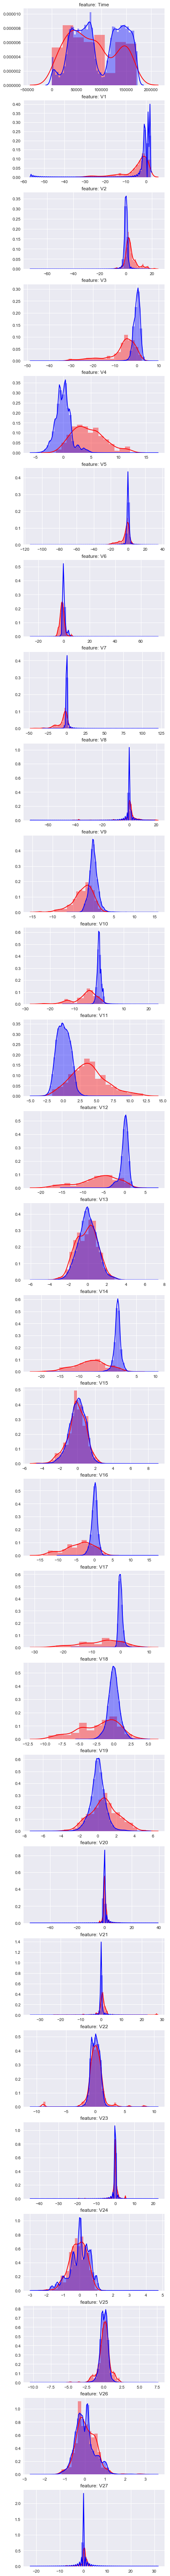

In [14]:
#Avaliando principais features através de histogramas de transações normais e transações fraudulentas 
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax1 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1] ,color='r')
    sns.distplot(df[col][df.Class == 0] ,color='b')
    ax1.set_xlabel('')
    ax1.set_title('feature: ' + str(col))
plt.show()

###  ERRO E PQ NÃO APARECE v28 ##

In [15]:
########## Classificando agora sem as features que não se mostravam relevantes
irrelevantes = ['Time','V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28']
df_select =  df.drop(irrelevantes,axis=1)

In [16]:
# separando dataset em base de treinamento e em base de teste


clas = df_select['Class'].values #fraude ou não
feat = df_select.drop(['Class'],axis=1).values #features
feat_train, feat_test, clas_train, clas_test = train_test_split(feat, clas, test_size=0.3, stratify=clas)


In [17]:
rl.fit(feat_train,clas_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
classe_teste = pd.DataFrame(clas_test)
probs = rl.predict_proba(feat_test)
probs_frame = pd.DataFrame(probs)
probs_frame.head()

,0,1
0,0.999927,0.000073
1,0.998847,0.001153
2,0.999624,0.000376
3,0.999918,0.000082
4,0.999919,0.000081


In [19]:
for index, row in probs_frame.iterrows():
    i = probs_frame.index.get_loc(index)
    if probs[i][0]>probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = '0'
    if probs[i][0]<probs[i][1]:
        probs_frame.loc[index, 'Classificação'] = '1'

In [20]:
Comparativo_select= pd.crosstab(classe_teste[0],probs_frame['Classificação'])
Comparativo_select

Classificação,0,1
0,,
0,85283,12
1,66,82


In [32]:
probs_frame['Classificação Real']=classe_teste[0]

In [ ]:
#parte final
# Num dataframe de apenas fraudes analisar as prob e achar uma media

In [51]:
##  PQ NÃO APARECE O FILTRO  ##
probs_frame[(probs_frame['Classificação Real']==1) & (probs_frame['Classificação']==0)]

,0,1,Classificação,Classificação Real


In [49]:
probs_frame[probs_frame['Classificação Real']==1]

,0,1,Classificação,Classificação Real
564,2.821396e-01,0.717860,1,1
1202,9.986150e-01,0.001385,0,1
1947,4.751179e-04,0.999525,1,1
2185,8.053074e-01,0.194693,0,1
2553,7.849911e-02,0.921501,1,1
5095,9.930048e-01,0.006995,0,1
5314,1.523555e-05,0.999985,1,1
5527,8.953801e-02,0.910462,1,1
6548,9.979403e-01,0.002060,0,1
7261,4.906919e-06,0.999995,1,1


In [56]:
for index, row in probs_frame.iterrows():
    i = probs_frame.index.get_loc(index)
    if probs[i][1]<0.008:
        probs_frame.loc[index, 'Filtro final'] = '0'
    if probs[i][1]>0.008:
        probs_frame.loc[index, 'Filtro final'] = '1'

In [57]:
Comparativo_select= pd.crosstab(classe_teste[0],probs_frame['Filtro final'])
Comparativo_select

Filtro final,0,1
0,,
0,84964,331
1,16,132
